## This notebook is designed to facilitate the exploitation of the GuitarSet database and the extraction of target matrices needed to train the model proposed in the article 'A Lightweight Instrument-Agnostic Model for Polyphonic Note Transcription and Multi-Pitch Estimation.'

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import jams
import csv
import pandas as pd
import random

## Exploring the Structure of the Dataset

In [2]:
# Paths to your folder containing the two subfolders "annotations" and "audio_hex-pickup_debleeded"
#base_dir = r"C:\Users\..." 

audio_dir = os.path.join(base_dir, "audio_hex-pickup_debleeded")  # Path to the "audio_hex-pickup_debleeded" subfolder
annotation_dir = os.path.join(base_dir, "annotation")  # Path to the "annotation" subfolder

In [3]:
# Example with an audio file
audio_file = os.path.join(audio_dir, "00_Jazz3-137-Eb_comp_hex_cln.wav") 

# Load the audio
y, sr = librosa.load(audio_file, sr=None)

# Display information
print(f"Duration: {librosa.get_duration(y=y, sr=sr):.2f} seconds")
print(f"Sampling rate: {sr} Hz")

# # Plot the waveform
# plt.figure(figsize=(10, 4))
# librosa.display.waveshow(y, sr=sr)
# plt.title("Waveform")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.show()

Duration: 28.02 seconds
Sampling rate: 44100 Hz


In [20]:
# Example with a JAMS file
jams_file = os.path.join(annotation_dir, "00_Jazz3-137-Eb_comp.jams")

# Load the file
jams = jams.load(jams_file)

# # Display available metadata and annotations
# print("Available annotations:", [annotation.namespace for annotation in jams.annotations])

## Preprocessing and Extracting Useful Annotations as CSV Files

In [4]:
# Output folder to store the useful annotations as CSV files
output_folder = r"C:\Users\..."

# Create train and test subfolders
train_folder = os.path.join(output_folder, "train")
test_folder = os.path.join(output_folder, "test")

for subfolder in ["pitch_contour", "midi_notes", "onsets"]:
    os.makedirs(os.path.join(train_folder, subfolder), exist_ok=True)
    os.makedirs(os.path.join(test_folder, subfolder), exist_ok=True)

# List all .jams files
jams_files = [f for f in os.listdir(annotation_dir) if f.endswith(".jams")]

# Shuffle and split into train and test (90% train, 10% test)
random.seed(42)  # For reproducibility
random.shuffle(jams_files)

split_index = int(0.9 * len(jams_files))
train_files = jams_files[:split_index]
test_files = jams_files[split_index:]

def process_files(file_list, destination_folder):
    for filename in file_list:
        # Load the JAMS file
        file_path = os.path.join(annotation_dir, filename)
        jams_data = jams.load(file_path)

        # Extract annotations
        pitch_contours = []
        midi_notes = []
        note_onsets = []

        for annotation in jams_data.annotations:
            if annotation.namespace == "pitch_contour":
                for obs in annotation.data:
                    pitch_contours.append({
                        "time": obs.time,
                        "index": obs.value.get("index", None),
                        "frequency": obs.value.get("frequency", None),
                        "voiced": obs.value.get("voiced", None),
                    })
            elif annotation.namespace == "note_midi":
                for obs in annotation.data:
                    midi_notes.append({
                        "time": obs.time,
                        "duration": obs.duration,
                        "note": obs.value,  # obs.value is a float for MIDI notes
                    })
                    note_onsets.append({"time": obs.time})

        # Save the labels into separate files
        base_name = os.path.splitext(filename)[0]

        # 1. Pitch Contour
        with open(os.path.join(destination_folder, "pitch_contour", f"{base_name}_pitch_contour.csv"), "w", newline="") as csvfile:
            fieldnames = ["time", "index", "frequency", "voiced"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(pitch_contours)

        # 2. MIDI Notes
        with open(os.path.join(destination_folder, "midi_notes", f"{base_name}_midi_notes.csv"), "w", newline="") as csvfile:
            fieldnames = ["time", "duration", "note"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(midi_notes)

        # 3. Note Onsets
        with open(os.path.join(destination_folder, "onsets", f"{base_name}_onsets.csv"), "w", newline="") as csvfile:
            fieldnames = ["time"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(note_onsets)

# Process train and test datasets
process_files(train_files, train_folder)
process_files(test_files, test_folder)

# print("Data split into train and test folders successfully.")


In [ ]:
# Output folder to store the useful annotations as CSV files
# output_folder = r"C:\Users\...."

# Create subfolders for the labels
os.makedirs(os.path.join(output_folder, "pitch_contour"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "midi_notes"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "onsets"), exist_ok=True)

# Loop through all .jams files
for filename in os.listdir(annotation_dir):
    if filename.endswith(".jams"):
        # Load the JAMS file
        file_path = os.path.join(annotation_dir, filename)
        jams_data = jams.load(file_path)

        # Extract annotations
        pitch_contours = []
        midi_notes = []
        note_onsets = []

        for annotation in jams_data.annotations:
            if annotation.namespace == "pitch_contour":
                for obs in annotation.data:
                    pitch_contours.append({
                        "time": obs.time,
                        "index": obs.value.get("index", None),
                        "frequency": obs.value.get("frequency", None),
                        "voiced": obs.value.get("voiced", None),
                    })
            elif annotation.namespace == "note_midi":
                for obs in annotation.data:
                    midi_notes.append({
                        "time": obs.time,
                        "duration": obs.duration,
                        "note": obs.value,  # obs.value is a float for MIDI notes
                    })
                    note_onsets.append({"time": obs.time})

        # Save the labels into separate files
        base_name = os.path.splitext(filename)[0]

        # 1. Pitch Contour
        with open(os.path.join(output_folder, "pitch_contour", f"{base_name}_pitch_contour.csv"), "w", newline="") as csvfile:
            fieldnames = ["time", "index", "frequency", "voiced"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(pitch_contours)

        # 2. MIDI Notes
        with open(os.path.join(output_folder, "midi_notes", f"{base_name}_midi_notes.csv"), "w", newline="") as csvfile:
            fieldnames = ["time", "duration", "note"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(midi_notes)

        # 3. Note Onsets
        with open(os.path.join(output_folder, "onsets", f"{base_name}_onsets.csv"), "w", newline="") as csvfile:
            fieldnames = ["time"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(note_onsets)

        # print(f"Labels generated for: {filename}")

### Generation of Target Matrices (yo, yn, yp) from Previously Extracted Annotations: pitch_contour, midi_notes, onsets

In [4]:
# Global parameters
hop_size = 0.011  # 11 ms between two frames
fmin = 27.5  # Minimum frequency (A0) in Hz
midi_min = 21  # Minimum MIDI note (A0)
num_semitones = 88  # Total number of semitones (piano A0-C8)
bins_per_semitone = 3
bins_per_octave = bins_per_semitone * 12

# Function to generate binary matrices for an audio file
def generate_matrices(onsets_path, midi_notes_path, pitch_contour_path, save_path):
    # Read the data
    onsets = pd.read_csv(onsets_path)
    midi_notes = pd.read_csv(midi_notes_path)
    pitch_contour = pd.read_csv(pitch_contour_path)
    
    # Calculate the total duration of the audio
    duration = max(
        onsets['time'].max(),
        midi_notes['time'].max() + midi_notes['duration'].max(),
        pitch_contour['time'].max()
    )
    num_frames = int(duration / hop_size)
    num_bins_yn_yo = num_semitones
    num_bins_yp = num_semitones * bins_per_semitone

    # Initialize matrices
    Yo = np.zeros((num_frames, num_bins_yn_yo))
    Yn = np.zeros((num_frames, num_bins_yn_yo))
    Yp = np.zeros((num_frames, num_bins_yp))
    
    # Generate Yn (note activations) and Yo (note onsets)
    for _, row in midi_notes.iterrows():
        onset_time = row['time']
        duration = row['duration']
        pitch = row['note']  # Note in MIDI format
        
        # Convert time to frame indices
        start_frame = int(onset_time / hop_size)
        end_frame = int((onset_time + duration) / hop_size)
        
        # Convert MIDI note to bin index
        bin_index = int(pitch - midi_min)
        
        # Activate Yn for frames where the note is active
        if 0 <= bin_index < num_bins_yn_yo and start_frame < num_frames:
            Yn[start_frame:end_frame, bin_index] = 1  # Activate bins for the duration
            
            # Activate Yo only at the note onset (precise instant)
            Yo[start_frame, bin_index] = 1  # Note onset for a specific pitch
    
    # Generate Yp (multipitch)
    for _, row in pitch_contour.iterrows():
        time = row['time']
        frequency = row['frequency']
        
        # Convert time to frame index
        time_frame = int(time / hop_size)
        
        # Ensure the time index is within bounds
        if not (0 <= time_frame < num_frames):
            print(f"Time frame out of bounds: {time_frame} (Max duration: {num_frames})")
            continue

        # Convert frequency to bin index
        if frequency > 0:  # Ignore zero frequencies
            bin_index = int((np.log2(frequency / fmin)) * bins_per_octave)
            
            # Normalize out-of-bounds indices
            bin_index = max(0, min(bin_index, num_bins_yp - 3))
            Yp[time_frame, bin_index:bin_index+3] = 1
    
    # Save the matrices
    os.makedirs(save_path, exist_ok=True)
    np.save(os.path.join(save_path, "Yo.npy"), Yo)
    np.save(os.path.join(save_path, "Yn.npy"), Yn)
    np.save(os.path.join(save_path, "Yp.npy"), Yp)
    # print(f"Matrices saved in {save_path}")

In [7]:
# Replace with the path containing the extracted annotations: pitch_contour, midi_notes, onsets for train and test
# base_path = r"C:\Users\...."  
# Directory to store the target matrices
# save_path = r"C:\Users\..."

subdirs = ["train", "test"]

# Loop through files in train and test directories
for subdir in subdirs:
    onsets_dir = os.path.join(base_path, subdir, "onsets")
    midi_notes_dir = os.path.join(base_path, subdir, "midi_notes")
    pitch_contour_dir = os.path.join(base_path, subdir, "pitch_contour")
    
    # Process all corresponding CSV files
    for file_name in os.listdir(onsets_dir):
        file_id = os.path.splitext(file_name)[0].replace("_onsets", "")  # Extract the file ID
        onsets_path = os.path.join(onsets_dir, file_name)
        midi_notes_path = os.path.join(midi_notes_dir, f"{file_id}_midi_notes.csv")
        pitch_contour_path = os.path.join(pitch_contour_dir, f"{file_id}_pitch_contour.csv")
         
        # # Check that all required files exist
        if os.path.exists(onsets_path) and os.path.exists(midi_notes_path) and os.path.exists(pitch_contour_path):
             # print(f"Processing files for {file_id}...")
            generate_matrices(onsets_path, midi_notes_path, pitch_contour_path, os.path.join(save_path , subdir, file_id))
        else:
            print(f"Missing files for {file_id}. Skipped.")

ok
Time frame out of bounds: 1780 (Max duration: 1780)
Time frame out of bounds: 2079 (Max duration: 2079)
Time frame out of bounds: 2013 (Max duration: 2013)
Time frame out of bounds: 2327 (Max duration: 2327)
Time frame out of bounds: 2029 (Max duration: 2029)
Time frame out of bounds: 1974 (Max duration: 1974)
Time frame out of bounds: 2001 (Max duration: 2001)
Time frame out of bounds: 3041 (Max duration: 3041)
Time frame out of bounds: 1864 (Max duration: 1864)
Time frame out of bounds: 3871 (Max duration: 3871)
Time frame out of bounds: 3849 (Max duration: 3849)
Time frame out of bounds: 2458 (Max duration: 2458)
Time frame out of bounds: 3116 (Max duration: 3116)
Time frame out of bounds: 3116 (Max duration: 3116)
Time frame out of bounds: 2547 (Max duration: 2547)
Time frame out of bounds: 3262 (Max duration: 3262)
ok
Time frame out of bounds: 1780 (Max duration: 1780)
Time frame out of bounds: 2266 (Max duration: 2266)
Time frame out of bounds: 2029 (Max duration: 2029)


### Display the time-frequency target matrices (for the total duration of the audio files)

Yo (file: Yo.npy) - Shape: (4037, 88)
Yn (file: Yn.npy) - Shape: (4037, 88)
Yp (file: Yp.npy) - Shape: (4037, 264)
Yo (file: Yo.npy) - Shape: (4110, 88)
Yn (file: Yn.npy) - Shape: (4110, 88)
Yp (file: Yp.npy) - Shape: (4110, 264)
Yo (file: Yo.npy) - Shape: (2386, 88)
Yn (file: Yn.npy) - Shape: (2386, 88)
Yp (file: Yp.npy) - Shape: (2386, 264)


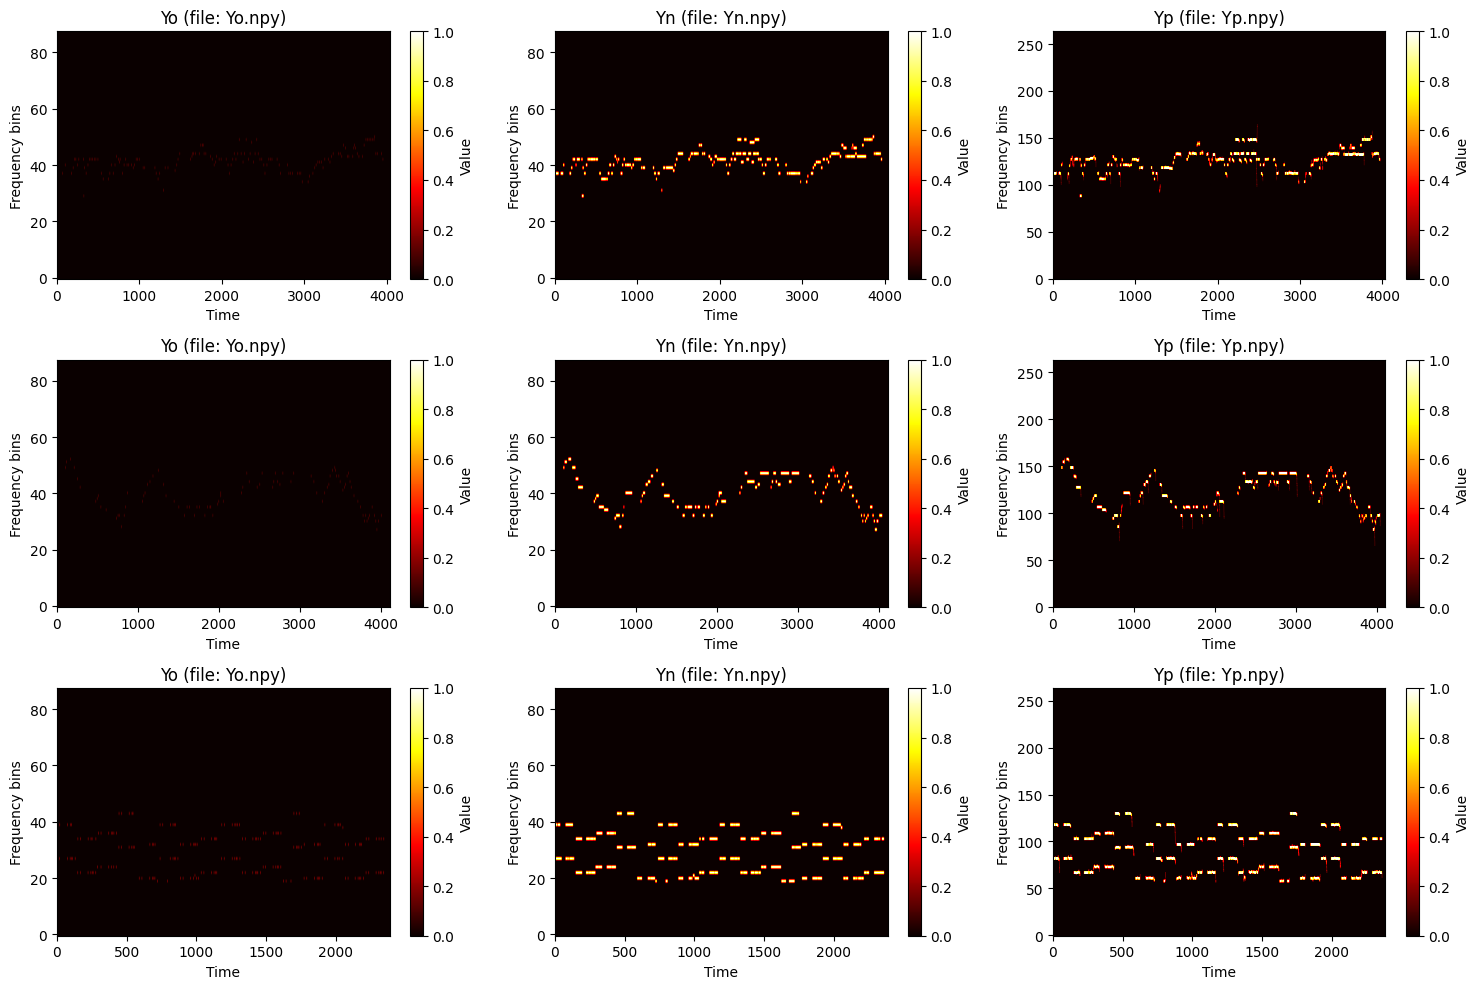

In [20]:
# Directory to the target matrices
# base_dir = r"C:\Users\ 

# Load all subdirectories (containing the matrices)
all_files = []
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    for file in os.listdir(subdir_path):
        # Find Yo.npy, Yn.npy, Yp.npy files
        file_path = os.path.join(subdir_path, file)
        files = {
            "Yo": os.path.join(file_path, "Yo.npy"),
            "Yn": os.path.join(file_path, "Yn.npy"),
            "Yp": os.path.join(file_path, "Yp.npy"),
        }
        if all(os.path.exists(f) for f in files.values()):
            all_files.append(files)

# Check if any files are available
if len(all_files) == 0:
    print("No matrix files found.")
else:
    # Select 2 or 3 matrices randomly
    selected_files = random.sample(all_files, min(3, len(all_files)))

    # Display the matrices
    plt.figure(figsize=(15, 10))
    for idx, file_set in enumerate(selected_files):
        for matrix_type, path in file_set.items():
            matrix = np.load(path)
            
            # Display the shape of the matrix
            print(f"{matrix_type} (file: {os.path.basename(path)}) - Shape: {matrix.shape}")
            
            # Plot the matrix
            plt.subplot(len(selected_files), 3, idx * 3 + list(file_set.keys()).index(matrix_type) + 1)
            plt.imshow(matrix.T, aspect="auto", origin="lower", cmap="hot")
            plt.colorbar(label="Value")
            plt.title(f"{matrix_type} (file: {os.path.basename(path)})")
            plt.xlabel("Time")
            plt.ylabel("Frequency bins")

    plt.tight_layout()
    plt.show()